In [1]:
# Import necessary libraries

import imp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mlb
import matplotlib.pyplot as plt
import os
import io

# to display images

import PIL
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, BinaryType
from pyspark.ml.linalg import Vectors, DenseVector, VectorUDT, Vectors 
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler
from pyspark.ml.image import ImageSchema
from pyspark.conf import SparkConf

import pyspark.sql.functions as F
from pyspark.sql.functions import *


#from keras.applications import inception_v3, xception, ResNet50
#from sparkdl import DeepImageFeaturizer

# setting
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns=200
pd.options.display.max_rows=200

2022-10-14 15:01:43.090498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:01:43.720935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-14 15:01:43.720977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-14 15:01:43.815059: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already

## scan the work / data directories and files 

In [2]:
os.getcwd()

'/home/houssein/Documents/openclassrooms/P8'

In [3]:
os.listdir()

['p8_pretreatment_reduction_2.ipynb',
 'data',
 'p8_pretreatment_reduction_5.ipynb',
 'p8_pretreatment_reduction.ipynb',
 'Franck_P8_Notebook_ec2.ipynb',
 'p8_pretreatment_reduction_4.ipynb',
 'p8_pretreatment_reduction_3.ipynb',
 'p8_pretreatment_reduction_6.ipynb',
 'p8_pretreatment_reduction_0.ipynb',
 '.ipynb_checkpoints',
 'Franck_P8_Notebook_local.ipynb',
 'archive(1).zip',
 'p8_pretreatment_reduction_1.ipynb',
 'archive.zip']

In [4]:
os.listdir('data/')

['Test', 'Meta', 'readme.md', 'Training', 'Validation', 'Papers']

In [5]:
os.listdir('data/Training/')

['apple_braeburn_1',
 'apple_red_1',
 'cabbage_white_1',
 'apple_pink_lady_1',
 'cucumber_3',
 'pear_3',
 'apple_red_delicios_1',
 'apple_crimson_snow_1',
 'apple_rotten_1',
 'apple_golden_1',
 'apple_golden_3',
 'zucchini_1',
 'cucumber_1',
 'apple_golden_2',
 'apple_hit_1',
 'pear_1',
 'eggplant_violet_1',
 'apple_red_3',
 'apple_6',
 'zucchini_dark_1',
 'apple_red_2',
 'carrot_1',
 'apple_red_yellow_1',
 'apple_granny_smith_1']

In [6]:
len(os.listdir('data/Training/'))

24

In [7]:
len(os.listdir('data/Training/'))

24

In [8]:
len(os.listdir('data/Training/cabbage_white_1/'))

96

## spark code for reading jpg files, extract features & excute a pca

In [9]:
# spark session creation 
#spark = SparkSession.builder.master("local[16]").appName("Fruits").getOrCreate()
#conf=SparkConf()


spark = SparkSession.builder \
      .master("local[*]") \
      .appName("Fruits") \
      .getOrCreate()
      # .config("spark.executor.memory", "16g") \
      # .config("spark.driver.memory", "8g") \

spark.sparkContext.setLogLevel("OFF")

sc = SparkContext.getOrCreate()

spark

22/10/14 15:01:51 WARN Utils: Your hostname, houssein-Latitude-E5440 resolves to a loopback address: 127.0.1.1; using 192.168.1.25 instead (on interface wlp2s0)
22/10/14 15:01:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/14 15:01:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
columns = ["path", "category", "filename", "image"]
l1 = []
for roots,dirs,files in os.walk('data/Training/'):
    for file in files:
        filename = os.path.join(roots,file)
        l = (roots, roots[39:], filename, file)
        l1.append(l)
    
rdd = spark.sparkContext.parallelize(l1)
df = rdd.toDF(columns)
df.show()

+--------------------+--------+--------------------+----------+
|                path|category|            filename|     image|
+--------------------+--------+--------------------+----------+
|data/Training/app...|        |data/Training/app...|r1_306.jpg|
|data/Training/app...|        |data/Training/app...| r0_52.jpg|
|data/Training/app...|        |data/Training/app...|r1_100.jpg|
|data/Training/app...|        |data/Training/app...|r1_130.jpg|
|data/Training/app...|        |data/Training/app...|r1_108.jpg|
|data/Training/app...|        |data/Training/app...|r0_100.jpg|
|data/Training/app...|        |data/Training/app...|r0_262.jpg|
|data/Training/app...|        |data/Training/app...|r1_256.jpg|
|data/Training/app...|        |data/Training/app...|r0_268.jpg|
|data/Training/app...|        |data/Training/app...| r0_56.jpg|
|data/Training/app...|        |data/Training/app...|r1_262.jpg|
|data/Training/app...|        |data/Training/app...|r1_224.jpg|
|data/Training/app...|        |data/Trai

In [11]:
print((df.count(), len(df.columns)))

(6231, 4)


In [12]:
df.select('filename').show(1, truncate=False)

+-----------------------------------------+
|filename                                 |
+-----------------------------------------+
|data/Training/apple_braeburn_1/r1_306.jpg|
+-----------------------------------------+
only showing top 1 row



## read images with tensorflow methodes

In [13]:
img_0_0 = df.select("filename").collect()[0][0]
print(img_0_0)

data/Training/apple_braeburn_1/r1_306.jpg


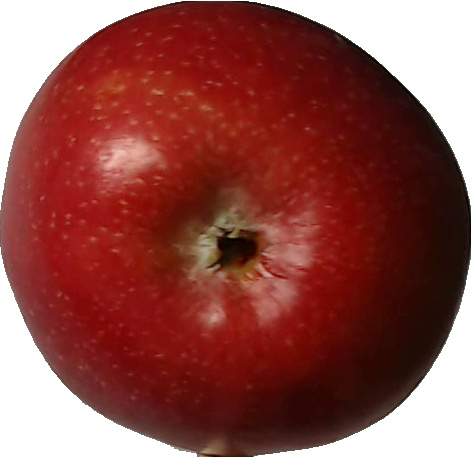

In [14]:
load_img(img_0_0)

2022-10-14 15:02:06.518079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-14 15:02:06.518420: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 15:02:06.518484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (houssein-Latitude-E5440): /proc/driver/nvidia/version does not exist
2022-10-14 15:02:06.519769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


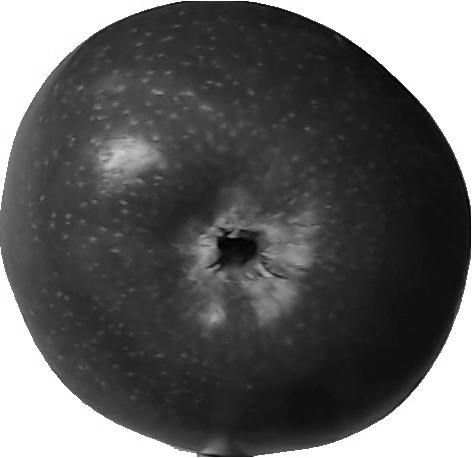

In [15]:
array_to_img(rgb_to_grayscale(img_to_array(load_img(img_0_0))))

In [16]:
img_to_array(array_to_img(rgb_to_grayscale(img_to_array(load_img(img_0_0)))))

array([[[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       ...,

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]]], dtype=float32)

In [17]:
# Select distinct rows (unique_values)
distinctDF = df.select("path").distinct()

print(distinctDF.count())

distinctDF = distinctDF.withColumn('path_all', concat(col('path'), lit("/*") ))

distinctDF.show(truncate=False)

distinctDF.collect()[0][0]


24
+----------------------------------+------------------------------------+
|path                              |path_all                            |
+----------------------------------+------------------------------------+
|data/Training/apple_red_1         |data/Training/apple_red_1/*         |
|data/Training/cabbage_white_1     |data/Training/cabbage_white_1/*     |
|data/Training/apple_pink_lady_1   |data/Training/apple_pink_lady_1/*   |
|data/Training/apple_braeburn_1    |data/Training/apple_braeburn_1/*    |
|data/Training/cucumber_3          |data/Training/cucumber_3/*          |
|data/Training/cucumber_1          |data/Training/cucumber_1/*          |
|data/Training/zucchini_1          |data/Training/zucchini_1/*          |
|data/Training/apple_golden_1      |data/Training/apple_golden_1/*      |
|data/Training/pear_3              |data/Training/pear_3/*              |
|data/Training/apple_golden_3      |data/Training/apple_golden_3/*      |
|data/Training/apple_rotten_1      

'data/Training/apple_red_1'

In [18]:
distinctDF.show(1, truncate=False)

+-------------------------+---------------------------+
|path                     |path_all                   |
+-------------------------+---------------------------+
|data/Training/apple_red_1|data/Training/apple_red_1/*|
+-------------------------+---------------------------+
only showing top 1 row



In [19]:
distinctDF.select('path_all').collect()[0][0]

'data/Training/apple_red_1/*'

In [20]:
#initiation phase first row (row = 0)
path_initiation = distinctDF.select('path_all').collect()[0][0]
img_all = spark.read.format("binaryfile").load(path_initiation)
#loop for to collect all photos
for row in range(1, distinctDF.count()):
    path_i = distinctDF.select('path_all').collect()[row][0]
    img_i = spark.read.format("binaryfile").load(path_i)
    img_all = img_all.union(img_i)

img_all.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [21]:
print((img_all.count(), len(img_all.columns)))

(6231, 4)


In [22]:
img_df = img_all.select("path", "content")
n_rows = img_df.count()
img_df = img_df.withColumn("target", split(col("path"), "/") \
    .getItem(8))
img_df.show(10)

+--------------------+--------------------+-----------+
|                path|             content|     target|
+--------------------+--------------------+-----------+
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
|file:/home/housse...|[FF D8 FF E0 00 1...|apple_red_1|
+--------------------+--------------------+-----------+
only showing top 10 rows



In [23]:
# # Les données images sont converties au format vecteur dense
# ud_f = udf(lambda x: Vectors.dense(x), VectorUDT())
# img_df = img_df.withColumn('vecs', ud_f('content'))
# img_df.show()

In [24]:
# len(img_df.collect()[0]['vecs'])

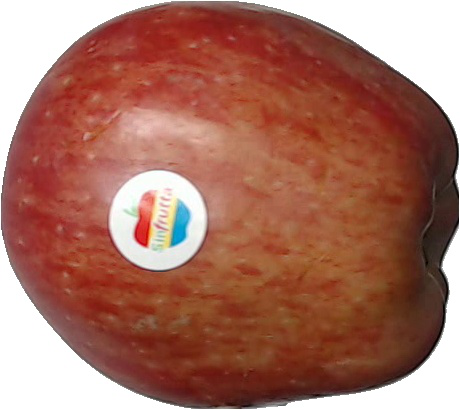

In [25]:
# Take first image of dataset
img_example = img_df.collect()[0]["content"]
# Convert from bytes to jpeg using tensorflow
img_example = load_img(io.BytesIO(img_example))

img_example

In [26]:
def resize_sq_fill_image(img, sq_size=224, fill_col=(255,255,255),
                 interpolation=Image.ANTIALIAS):
    '''
    this function takes an image, resizes the image and fills the non existing space
    with custom color

    Argumants:
        img: image in np or PIL format    
        sq_size: size request    
        fill_col: fill color request
    
    returns:
        new_img: image resized with fill color
    '''    
    w, h = img.size
    if h != w:
        dif = h if h > w else w
        new_img = Image.new('RGB', (dif, dif), fill_col)
        new_img.paste(img, (int((dif - w) / 2), int((dif - h) / 2)))
        img = new_img
    
    # Change format to np.array and resize with cv2
    new_img = cv2.resize(np.asarray(img), (sq_size, sq_size), interpolation)
    return np.array(new_img)

In [27]:
img_resize = resize_sq_fill_image(img_example)

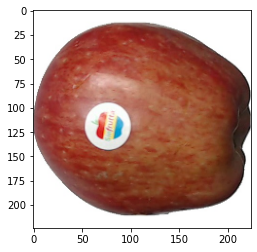

In [28]:
plt.imshow(img_resize)

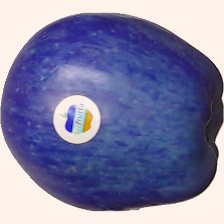

In [29]:
img_process = preprocess_input(img_resize)
array_to_img(img_process)

## CNN Transfert Learnning - Features Extraction

### model preparation

In [30]:
# model without top layers
model_vgg16 = VGG16(weights="imagenet", 
                    include_top=False,
                    pooling='max', 
                    input_shape=(224, 224, 3))

model_vgg16.summary()  

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Les workers de Spark ont besoin d'accéder au modèle et à ses poids. Téléchargement du modèle vers le pilote Spark, puis diffusion des poids aux workers dirigés par le sc (sparkContext).

In [31]:
# Sérialise le modèle pour une execution plus rapide
sc = spark.sparkContext
model_bc = sc.broadcast(model_vgg16)

INFO:tensorflow:Assets written to: ram://0eabe7b8-ca0f-4ebd-9303-f8fab4b4affa/assets


INFO:tensorflow:Assets written to: ram://0eabe7b8-ca0f-4ebd-9303-f8fab4b4affa/assets


### preprocessing

Preprocessing on binaries data for each image

In [32]:
def extract(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = load_img(io.BytesIO(content), target_size=(224, 224, 3)) #open the binaries data image and resized
    
    arr = img_to_array(img) #image to array

    arr = np.expand_dims(arr, axis=0)
    proc = preprocess_input(arr) # Preprocessing pour les besoins du modèle (soustraction de la moyenne RGB du modèle d'entrainement)
    features = model_bc.value.predict(proc,verbose=0) # .value car modèle sérialisé
    vector_feature = Vectors.dense(features.ravel().tolist())    
    return vector_feature

In [33]:
# Take first image of dataset
img_example = img_df.collect()[0]["content"]
# Convert from bytes to jpeg using tensorflow
img_example = load_img(io.BytesIO(img_example), target_size=(224, 224, 3))
img_example = img_to_array(img_example)
img_example = np.expand_dims(img_example, axis=0)
img_example = preprocess_input(img_example)
img_example = model_bc.value.predict(img_example,verbose=0)
img_example = Vectors.dense(img_example.ravel().tolist()) 

img_example

DenseVector([35.4705, 0.0, 20.7305, 0.0, 5.6498, 21.2434, 0.0, 0.0, 0.0, 0.0, 28.3995, 0.0, 0.6267, 0.0, 46.8603, 0.0, 10.9305, 0.0, 79.083, 24.0312, 0.0, 0.0, 3.1269, 0.0, 54.8756, 36.9003, 11.2307, 28.5537, 42.9238, 88.0616, 4.9213, 11.7072, 74.8671, 54.596, 0.0, 69.019, 58.0406, 1.1992, 0.0, 3.3534, 69.376, 77.5473, 27.9972, 57.5059, 6.9936, 0.0, 86.1196, 25.6079, 1.5516, 0.0, 16.0841, 0.0, 29.2817, 18.7663, 22.1895, 0.1681, 47.653, 0.0, 5.4465, 71.3607, 27.7176, 9.6608, 81.0813, 43.1006, 31.6403, 4.2118, 17.1947, 78.3918, 43.2087, 5.6505, 0.0, 23.5672, 35.3552, 72.2233, 36.4804, 0.0, 40.6176, 3.3899, 0.0, 0.0, 0.0141, 42.2369, 57.8136, 6.0639, 15.6592, 64.2937, 39.8551, 61.6232, 0.0, 31.8131, 0.0, 0.0, 5.307, 0.0, 28.8179, 29.7339, 5.7331, 26.6032, 26.6879, 33.5285, 48.3687, 14.2028, 0.8854, 10.317, 0.0, 0.0, 0.0, 49.7103, 8.7714, 80.2807, 70.4441, 9.7315, 0.0, 0.2086, 0.0, 0.0, 20.0021, 8.3735, 0.0, 55.9949, 20.5224, 37.3362, 33.1997, 36.3741, 0.0, 35.5714, 0.0, 0.0, 14.1207, 11.4

In [34]:
extract_features = udf(lambda x: extract(x), VectorUDT()) # UDF est la fonction spark de apply

img_df = img_df.withColumn('vgg16vec', extract_features('content')).select('path', 'target', 'vgg16vec') 
img_df.show(10)
img_df.persist() # Pour le conserver en mémoire

2022-10-14 15:03:40.232169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:03:40.531036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-14 15:03:40.531076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-14 15:03:40.579579: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already

+--------------------+-----------+--------------------+
|                path|     target|            vgg16vec|
+--------------------+-----------+--------------------+
|file:/home/housse...|apple_red_1|[35.4704971313476...|
|file:/home/housse...|apple_red_1|[28.8226451873779...|
|file:/home/housse...|apple_red_1|[33.7774162292480...|
|file:/home/housse...|apple_red_1|[52.8479843139648...|
|file:/home/housse...|apple_red_1|[30.8820648193359...|
|file:/home/housse...|apple_red_1|[53.9875526428222...|
|file:/home/housse...|apple_red_1|[27.1955051422119...|
|file:/home/housse...|apple_red_1|[39.0906219482421...|
|file:/home/housse...|apple_red_1|[17.6778850555419...|
|file:/home/housse...|apple_red_1|[62.7256050109863...|
+--------------------+-----------+--------------------+
only showing top 10 rows



DataFrame[path: string, target: string, vgg16vec: vector]

In [35]:
# Standardisation des données
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='vgg16vec',
                              outputCol='features_scaled')
std = standardizer.fit(img_df)
img_df_std = std.transform(img_df)
img_df_std = img_df_std.select('path', 'target', 'vgg16vec', 'features_scaled')

2022-10-14 15:04:03.485128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:04:03.557783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:04:03.559044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-10-14 15:04:11.075052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-14 15:04:11.075449: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 15:04:11.078312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (houssein-Latitude-E5440): /proc/driver/nvidia/version does not exist
2022-10-14 15:04:11.081047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:

In [36]:
img_df_std.show(10)

+--------------------+-----------+--------------------+--------------------+
|                path|     target|            vgg16vec|     features_scaled|
+--------------------+-----------+--------------------+--------------------+
|file:/home/housse...|apple_red_1|[35.4704971313476...|[-0.3520240672143...|
|file:/home/housse...|apple_red_1|[28.8226451873779...|[-0.6348065115845...|
|file:/home/housse...|apple_red_1|[33.7774162292480...|[-0.4240433540528...|
|file:/home/housse...|apple_red_1|[52.8479843139648...|[0.38716933599749...|
|file:/home/housse...|apple_red_1|[30.8820648193359...|[-0.5472041217573...|
|file:/home/housse...|apple_red_1|[53.9875526428222...|[0.43564362818648...|
|file:/home/housse...|apple_red_1|[27.1955051422119...|[-0.7040208447530...|
|file:/home/housse...|apple_red_1|[39.0906219482421...|[-0.1980333115124...|
|file:/home/housse...|apple_red_1|[17.6778850555419...|[-1.1088758107449...|
|file:/home/housse...|apple_red_1|[62.7256050109863...|[0.80733779775134...|

In [37]:
pca = PCA(k=512, inputCol="features_scaled", outputCol="Features_PCA")
pca_model = pca.fit(img_df_std)

result = pca_model.transform(img_df_std).select('path', 'target', 'vgg16vec', 'features_scaled', "Features_PCA")

result.show(10)

+--------------------+-----------+--------------------+--------------------+--------------------+
|                path|     target|            vgg16vec|     features_scaled|        Features_PCA|
+--------------------+-----------+--------------------+--------------------+--------------------+
|file:/home/housse...|apple_red_1|[35.4704971313476...|[-0.3520240672143...|[1.25573594722608...|
|file:/home/housse...|apple_red_1|[28.8226451873779...|[-0.6348065115845...|[1.10311234811401...|
|file:/home/housse...|apple_red_1|[33.7774162292480...|[-0.4240433540528...|[1.36203321742484...|
|file:/home/housse...|apple_red_1|[52.8479843139648...|[0.38716933599749...|[1.40571726545119...|
|file:/home/housse...|apple_red_1|[30.8820648193359...|[-0.5472041217573...|[1.76572611530338...|
|file:/home/housse...|apple_red_1|[53.9875526428222...|[0.43564362818648...|[1.73475833080905...|
|file:/home/housse...|apple_red_1|[27.1955051422119...|[-0.7040208447530...|[1.96568029776020...|
|file:/home/housse..

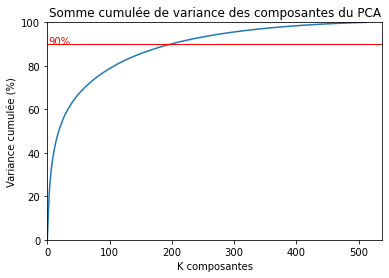

In [38]:
# Calcul du % de variance expliqué par la PCA
var = pca_model.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(512+1)], 
             y=np.insert(var, 0, 0)*100)
plt.title('Somme cumulée de variance des composantes du PCA')
plt.xlabel('K composantes')
plt.ylabel('Variance cumulée (%)')
plt.ylim(0, 100)
plt.xlim(left=0)
plt.axhline(90, lw=1, c='red')
plt.text(1, 90, '90%', c='red')
plt.show()